# Adam's batch reduction testing routines

Last updated 15 December 2022

## Goals:
Test pyspextool components:
* reduction of spex prism point source & extended source
 - status: not yet developed
* reduction of spex SXD point source & extended source
 - status: not yet developed
* reduction of spex LXD point source & extended source
 - status: not yet developed
* reduction of uspex prism point source & extended source
 - status: PS proceeds to aperture definition, XS proceeds to extraction, no 2D yet
* reduction of uspex SXD point source & extended source
 - status: PS proceeds to aperture definition, XS proceeds to extraction, no 2D yet
* reduction of uspex LXD point source & extended source
 - status: not yet developed

Develop functions for batch data preparation
* Legacy data organization by night/PI
 - status: preliminary script for spex data functioning, 2001-2004 organized; uspex data not yet developed
* IRSA data organization by night/PI
 - status: not yet developed
* Generation of log file
 - status: completed for spex data; uspex data not yet developed
* Organization of observations (science targets, calibration targets, source information)
 - status: preliminary script for spex data functioning; uspex data not yet developed
* Generation of batch driving script
 - status: preliminary script for spex data functioning; uspex data not yet developed

Develop functions for reduced data QA organization
* Organizing and plotting of reduced data
 - status: preliminary script for spex data functioning; uspex data not yet developed
* Organizing of QA information
 - status: not yet developed
* Web portal for review
 - status: preliminary scripts, organization needs further thought

Conduct batch reduction
* Reduced Legacy data
 - status: not yet begun
* Reduced IRSA data
 - status: not yet begun

Organization of final data products
* Data organized for integration into SIMPLE database
 - status: not yet begun
* Data organized for integration into IRSA database
 - status: not yet begun

 
 

In [30]:
# Imports and additional functions
import pyspextool
import glob
import numpy
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

# Function to read in output spectraN.fits file for xs in A-sky mode 
# data format is [# apertures x # orders, wave/flx/unc/back, column]
# returns wave, flux, unc(?), flags(?)

def xs_asky_to_spec(file,order):
    hdu = fits.open(file)
    data = hdu[0].data
    header = hdu[0].header # return this?
    hdu.close()
    orders = header['ORDERS'].split(',')
    orders = [int(x) for x in orders]
    if order > numpy.nanmax(orders) or order < numpy.nanmin(orders):
        raise ValueError('Input order {} is not in range of obtained orders {}'.format(order,orders))
    iref = orders.index(order)
    wave = data[2*iref,0,:]
    flux = data[2*iref,1,:]-data[2*iref+1,1,:]
#    unc = data[2*iref,2,:]
    unc = (0.5*(data[2*iref,2,:]**2+data[2*iref+1,2,:]**2))**0.5
    flags = data[2*iref,3,:]
    return wave, flux, unc, flags
    

# pyspextool component testing

Download test data files from https://splat.physics.ucsd.edu/downloads/pyspextool/


## uspex SXD data test

In [31]:
# set default parameters
data_folder = '/Users/adam/projects/spex_archive/testdata_uspex-SXD/'
cal_folder = '/Users/adam/projects/spex_archive/test_uspex-SXD/'
proc_folder = '/Users/adam/projects/spex_archive/test_uspex-SXD/'
qa_folder = '/Users/adam/projects/spex_archive/test_uspex-SXD/'

instrument = 'uspex'
prefix = 'spc-'
src_files = '1-2'
arc_file = '22'
flat_files = '18-21'
orders = '3-9'
source_type = 'xs'
aperture_positions = [3.7, 11.2]
ps_aperture = 1.5
psf_radius = 1.5
ps_bg_parameters = [2.5,4]
xs_aperture = [3,3]
xs_bg_regions = [[0.5,2.],[12.5,14]]


Pyspextool Setup
----------------
Instrument:  uspex

rawpath:  /Users/adam/projects/spex_archive/testdata_uspex-SXD
calpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
procpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
qapath:  /Users/adam/projects/spex_archive/test_uspex-SXD
 
Creating the flat field...
Loading FITS images...
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Writing flat to disk...
Flat field flat18-21.fits written to disk.
 
Creating the wavecal file...
Loading FITS images...
Extracting apertures...
100% |**********************************************************************|
Finding the lines...


/Users/adam/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
Determining the wavelength solution...
Writing wavecal to disk...


Wavecal wavecal22.fits written to disk.


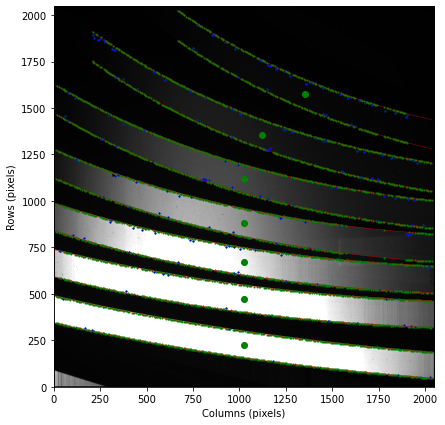

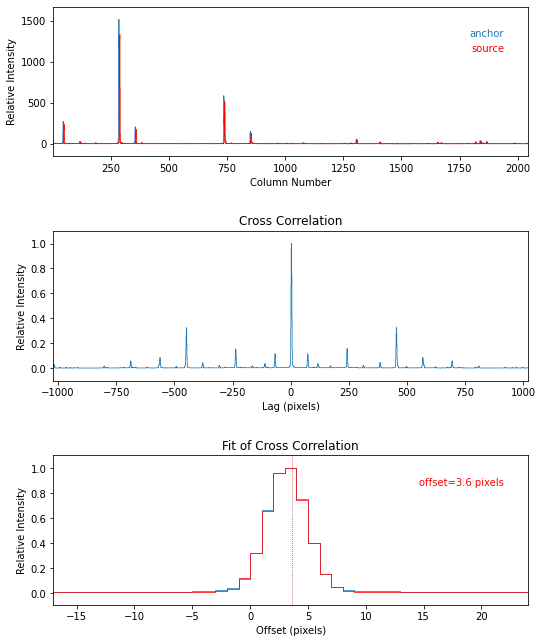

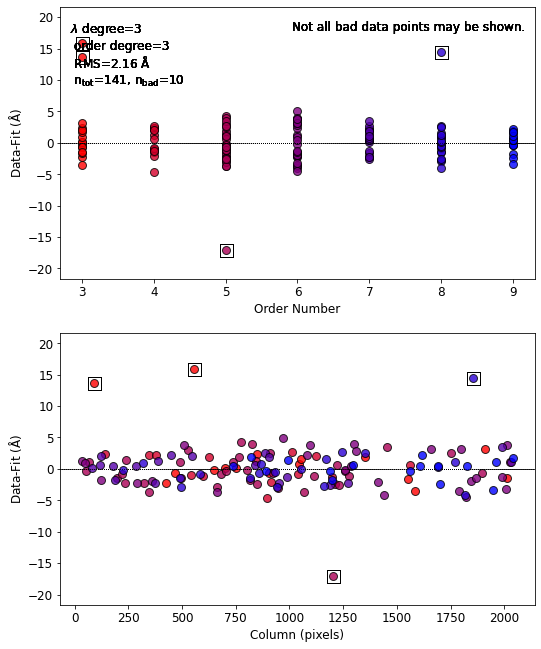

In [32]:
# calibration file generation
from pyspextool.cl import config, setup
from pyspextool.cl.make_uspex_flat import make_uspex_flat
from pyspextool.cl.make_uspex_wavecal import make_uspex_wavecal

#setup
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# generate flat field
make_uspex_flat(flat_files,'flat{}'.format(flat_files),qafile=True)

# wavelength calibration
make_uspex_wavecal(arc_file,'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_file),qafile_findlines=True, use_stored_solution=False)


In [35]:
# aperture selection and definition
from pyspextool.cl import setup
from pyspextool.cl.load_image import load_image
from pyspextool.cl.set_extraction_type import set_extraction_type
from pyspextool.cl.make_spatial_profiles import make_spatial_profiles
from pyspextool.cl.locate_aperture_positions import locate_aperture_positions
from pyspextool.cl.define_aperture_parameters import define_aperture_parameters
from pyspextool.cl.select_orders import select_orders
from pyspextool.cl.trace_apertures import trace_apertures

#setup - redo if restarting here
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# load image
load_image([src_files, prefix], 'flat{}.fits'.format(flat_files),'wavecal{}.fits'.format(arc_file),
            flat_field=True, linearity_correction=False, iplot=False, qafile=False)

# set up extraction - change to ps to check on auto and guess aperture location
source_type='xs'
set_extraction_type(source_type)

make_spatial_profiles(iplot=False, qafile=True)

# locate and trace orders - change method to match desired test
method = 'auto'
if method=='auto' and source_type=='ps':
    locate_aperture_positions(2, method=method, iplot=False, qafile=True)
elif method=='guess' and source_type=='ps':
    locate_aperture_positions(aperture_positions, method=method, iplot=False, qafile=True)
else:
    locate_aperture_positions(aperture_positions, method='fixed', iplot=False, qafile=True)
    
select_orders(include=orders, iplot=False, qafile=True)

trace_apertures(iplot=False, qafile=True)

if source_type=='ps':
    define_aperture_parameters(ps_aperture, iplot=False, psf_radius=psf_radius, bg_radius=ps_bg_parameters[0],bg_width=ps_bg_parameters[1], qafile=True)
else:
    define_aperture_parameters(xs_aperture, bg_regions=xs_bg_regions, iplot=False, qafile=True)

    

Pyspextool Setup
----------------
Instrument:  uspex

rawpath:  /Users/adam/projects/spex_archive/testdata_uspex-SXD
calpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
procpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
qapath:  /Users/adam/projects/spex_archive/test_uspex-SXD
Loading the flat...
Loading the wavecal...
/Users/adam/python_codes/pyspextool/data/atran100.fits
Loading the image and not correcting for non-linearity...
Flat fielding the image...
Setting extraction type to extended source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, +)...
100% |**********************************************************************|
Updating order selection...
100% |**********************************************************************|
100% |**********************************************************************|


In [36]:
# source extraction
# note that this currently only works for xs mode, and does a boxcar summ
from pyspextool.cl.extract_apertures import extract_apertures

extract_apertures()


Extracting apertures...
100% |**********************************************************************|


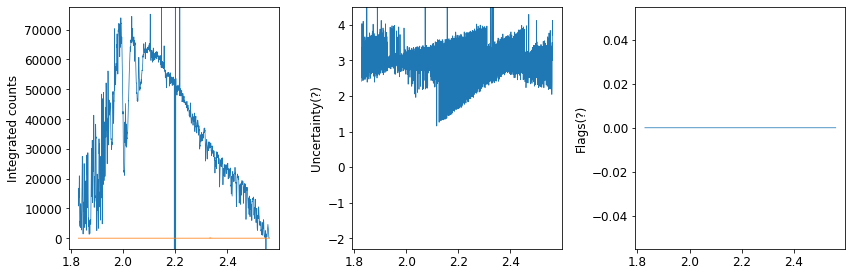

In [37]:
# examine output
file = proc_folder+'spectra00001.fits'

w,f,u,fl = xs_asky_to_spec(file,3)
fig = plt.figure(figsize=[12,4])
ax1 = plt.subplot(131)
ax1.plot(w,f)
ax1.plot(w,u)
ax1.set_ylim([-1.,1.2]*numpy.nanquantile(f,[0.05,0.95]))
ax1.set_ylabel('Integrated counts')
ax2 = plt.subplot(132)
ax2.plot(w,u)
ax2.set_ylim([-1.,1.2]*numpy.nanquantile(u,[0.05,0.95]))
ax2.set_ylabel('Uncertainty(?)')
ax3 = plt.subplot(133)
ax3.plot(w,fl)
ax3.set_ylabel('Flags(?)')
plt.tight_layout()
plt.show()


# uspex prism data test


In [38]:
# set default parameters
data_folder = '/Users/adam/projects/spex_archive/testdata_uspex-prism/'
cal_folder = '/Users/adam/projects/spex_archive/test_uspex-prism/'
proc_folder = '/Users/adam/projects/spex_archive/test_uspex-prism/'
qa_folder = '/Users/adam/projects/spex_archive/test_uspex-prism/'

instrument = 'uspex'
prefix = 'sbd.2022B046.221019.spc.'
src_files = '1-2'
arc_file = '20'
flat_files = '15-19'
orders = '1'
source_type = 'xs'
aperture_positions = [3.7, 11.2]
ps_aperture = 1.5
psf_radius = 1.5
ps_bg_parameters = [2.5,4]
xs_aperture = [3,3]
xs_bg_regions = [[0.5,2.],[12.5,14]]


Pyspextool Setup
----------------
Instrument:  uspex

rawpath:  /Users/adam/projects/spex_archive/testdata_uspex-prism
calpath:  /Users/adam/projects/spex_archive/test_uspex-prism
procpath:  /Users/adam/projects/spex_archive/test_uspex-prism
qapath:  /Users/adam/projects/spex_archive/test_uspex-prism
 
Creating the flat field...
Loading FITS images...
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Writing flat to disk...
Flat field flat15-19.fits written to disk.
 
Creating the wavecal file...
Loading FITS images...
Extracting apertures...
100% |**********************************************************************|
Finding the lines...


/Users/adam/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
Determining the wavelength solution...
hi
Writing wavecal to disk...


Wavecal wavecal20.fits written to disk.


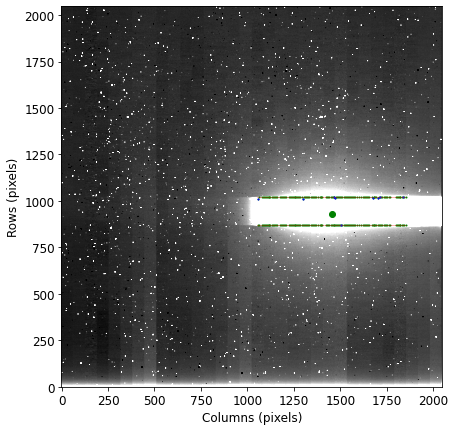

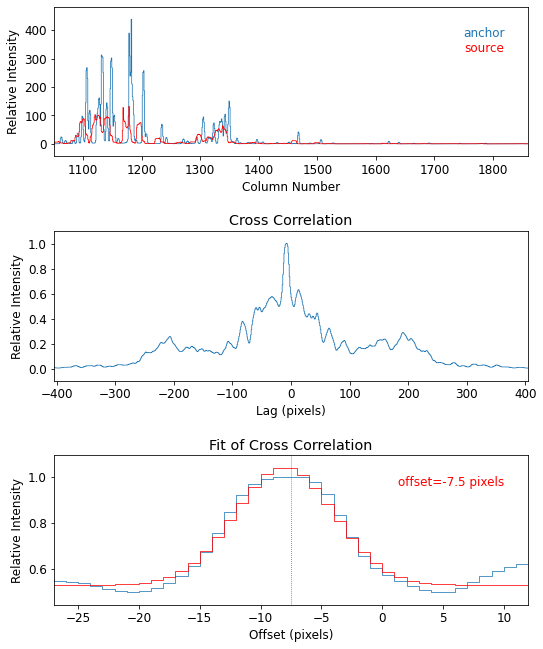

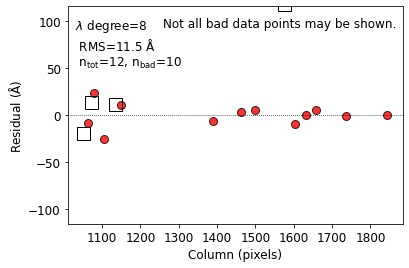

In [39]:
from pyspextool.cl import config, setup
from pyspextool.cl.make_uspex_flat import make_uspex_flat
from pyspextool.cl.make_uspex_wavecal import make_uspex_wavecal

#setup
# NOTE: SETTING INSTRUMENT TO SPEX FAILS
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# generate flat field
make_uspex_flat(flat_files,'flat{}'.format(flat_files),prefix=prefix.replace('spc','flat'),qafile=True)

# wavelength calibration
# ISSUES: does not compute covariance
make_uspex_wavecal(arc_file,'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_file),prefix=prefix.replace('spc','arc'),qafile_findlines=True, use_stored_solution=False)



In [40]:
# aperture selection and definition
from pyspextool.cl import setup
from pyspextool.cl.load_image import load_image
from pyspextool.cl.set_extraction_type import set_extraction_type
from pyspextool.cl.make_spatial_profiles import make_spatial_profiles
from pyspextool.cl.locate_aperture_positions import locate_aperture_positions
from pyspextool.cl.define_aperture_parameters import define_aperture_parameters
from pyspextool.cl.select_orders import select_orders
from pyspextool.cl.trace_apertures import trace_apertures

#setup - redo if restarting here
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# load image
load_image([src_files, prefix], 'flat{}.fits'.format(flat_files),'wavecal{}.fits'.format(arc_file),
            flat_field=True, linearity_correction=False, iplot=False, qafile=False)

# set up extraction - change to ps to check on auto and guess aperture location
source_type='xs'
set_extraction_type(source_type)

make_spatial_profiles(iplot=False, qafile=True)

# locate and trace orders - change method to match desired test
method = 'auto'
if method=='auto' and source_type=='ps':
    locate_aperture_positions(2, method=method, iplot=False, qafile=True)
elif method=='guess' and source_type=='ps':
    locate_aperture_positions(aperture_positions, method=method, iplot=False, qafile=True)
else:
    locate_aperture_positions(aperture_positions, method='fixed', iplot=False, qafile=True)
    
select_orders(include=orders, iplot=False, qafile=True)

trace_apertures(iplot=False, qafile=True)

if source_type=='ps':
    define_aperture_parameters(ps_aperture, iplot=False, psf_radius=psf_radius, bg_radius=ps_bg_parameters[0],bg_width=ps_bg_parameters[1], qafile=True)
else:
    define_aperture_parameters(xs_aperture, bg_regions=xs_bg_regions, iplot=False, qafile=True)

    

Pyspextool Setup
----------------
Instrument:  uspex

rawpath:  /Users/adam/projects/spex_archive/testdata_uspex-prism
calpath:  /Users/adam/projects/spex_archive/test_uspex-prism
procpath:  /Users/adam/projects/spex_archive/test_uspex-prism
qapath:  /Users/adam/projects/spex_archive/test_uspex-prism
Loading the flat...
Loading the wavecal...
/Users/adam/python_codes/pyspextool/data/atran100.fits
Loading the image and not correcting for non-linearity...
Flat fielding the image...
Setting extraction type to extended source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, +)...
100% |**********************************************************************|
Updating order selection...
100% |**********************************************************************|
100% |**********************************************************************|


In [41]:
# source extraction
# note that this currently only works for xs mode, and does a boxcar summ
from pyspextool.cl.extract_apertures import extract_apertures

extract_apertures()


Extracting apertures...
100% |**********************************************************************|


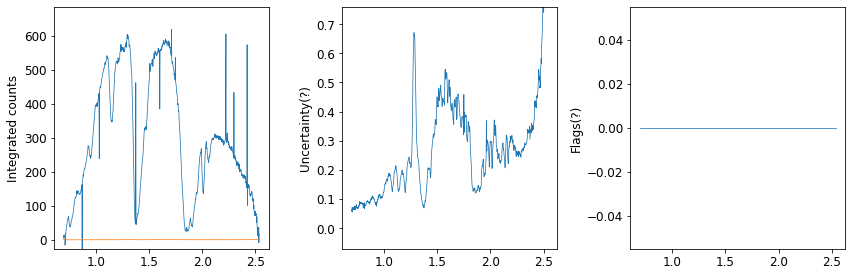

In [42]:
# examine output
file = proc_folder+'spectra00001.fits'

w,f,u,fl = xs_asky_to_spec(file,1)
fig = plt.figure(figsize=[12,4])
ax1 = plt.subplot(131)
ax1.plot(w,f)
ax1.plot(w,u)
ax1.set_ylim([-1.,1.2]*numpy.nanquantile(f,[0.05,0.95]))
ax1.set_ylabel('Integrated counts')
ax2 = plt.subplot(132)
ax2.plot(w,u)
ax2.set_ylim([-1.,1.2]*numpy.nanquantile(u,[0.05,0.95]))
ax2.set_ylabel('Uncertainty(?)')
ax3 = plt.subplot(133)
ax3.plot(w,fl)
ax3.set_ylabel('Flags(?)')
plt.tight_layout()
plt.show()


# spex prism data test

NOTE: THIS DOES NOT CURRENTLY WORK

Downloads as needed:
* Get prism data from (TBD)
* Get spex instrument file (TBD)


In [ ]:
# set default parameters
data_folder = '/Users/adam/projects/spex_archive/data_spex-prism/'
cal_folder = '/Users/adam/projects/spex_archive/test_spex-prism/'
proc_folder = '/Users/adam/projects/spex_archive/test_spex-prism/'
qa_folder = '/Users/adam/projects/spex_archive/test_spex-prism/'

instrument = 'spex'
prefix = 'fname-'
src_files = '19-20'
arc_file = '39'
flat_files = '34-38'
orders = '1'
source_type = 'xs'
aperture_positions = [3.7, 11.2]
ps_aperture = 1.5
psf_radius = 1.5
ps_bg_parameters = [2.5,4]
xs_aperture = [3,3]
xs_bg_regions = [[0.5,2.],[12.5,14]]


In [ ]:
from pyspextool.cl import config, setup
from pyspextool.cl.make_uspex_flat import make_uspex_flat
from pyspextool.cl.make_uspex_wavecal import make_uspex_wavecal

#setup
# NOTE: SETTING INSTRUMENT TO SPEX FAILS
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# generate flat field
make_uspex_flat(flat_files,'flat{}'.format(flat_files),qafile=True)

# wavelength calibration
# NOTE: THIS FAILS - HAVE INCLUDED FAKE FILE IN TEST OUTPUT
make_uspex_wavecal(arc_file,'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_file),qafile_findlines=True, use_stored_solution=False)



In [ ]:
# aperture selection and definition
from pyspextool.cl import setup
from pyspextool.cl.load_image import load_image
from pyspextool.cl.set_extraction_type import set_extraction_type
from pyspextool.cl.make_spatial_profiles import make_spatial_profiles
from pyspextool.cl.locate_aperture_positions import locate_aperture_positions
from pyspextool.cl.define_aperture_parameters import define_aperture_parameters
from pyspextool.cl.select_orders import select_orders
from pyspextool.cl.trace_apertures import trace_apertures

#setup - redo if restarting here
# NOTE: SETTING INSTRUMENT TO SPEX FAILS
pyspextool.cl.setup.setup(instrument,rawpath=data_folder,qapath=qa_folder,calpath=cal_folder,procpath=proc_folder)

# load image
# this fails on loading OLD wavecal because 
#(1) old version refers to hdu[1] instead of hdu[0] and 
#(2) ROTATION keyword missing
load_image([src_files, prefix], 'flat{}.fits'.format(flat_files),'wavecal{}.fits'.format(arc_file),
            flat_field=True, linearity_correction=False, iplot=False, qafile=False)

# set up extraction
source_type='ps'

set_extraction_type(source_type)

make_spatial_profiles(iplot=False, qafile=True)

# locate and trace orders
method = 'auto'
if method=='auto' and source_type=='ps':
    locate_aperture_positions(2, method=method, iplot=False, qafile=True)
elif method=='guess' and source_type=='ps':
    locate_aperture_positions(aperture_positions, method=method, iplot=False, qafile=True)
else:
    locate_aperture_positions(aperture_positions, method='fixed', iplot=False, qafile=True)
    
select_orders(include=orders, iplot=False, qafile=True)

trace_apertures(iplot=False, qafile=True)

if source_type=='ps':
    define_aperture_parameters(ps_aperture, iplot=False, psf_radius=psf_radius, bg_radius=bg_parameters[0],bg_width=bg_parameters[1], qafile=True)
else:
    define_aperture_parameters(xs_aperture, bg_regions=xs_bg_regions, iplot=False, qafile=True)

    